# Fixing the Vent Height Problem



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088
vent_height = 3085

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
0,VF95-06a,3133,9522,417.20,40,0.0,11.0,21.0,22.0,23.0,17.0,4.0,0.0,0.0,10024.179418
1,VF95-08a,1907,8096,312.90,30,1.0,13.0,19.0,24.0,25.0,16.0,3.0,0.0,0.0,8317.563646
2,VF97-20Q,5500,8723,208.60,20,2.0,7.0,14.0,21.0,26.0,21.0,6.0,1.0,1.0,10312.164128
3,VF98-01a3,2665,9054,239.89,23,4.0,13.0,18.0,21.0,23.0,15.0,3.0,0.0,0.0,9438.068711
4,VF98-02a,1154,7735,156.45,15,1.0,12.0,19.0,23.0,24.0,17.0,3.0,0.0,0.0,7820.610015


## Preprossessing Steps

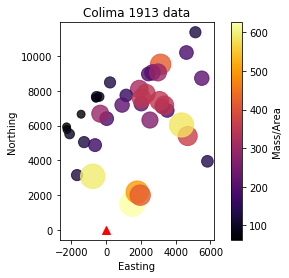

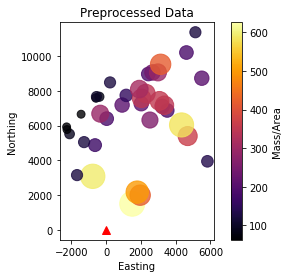

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.730,23.15290,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.010359,2124.861643,117.086929
18,1957,1997,0,691.154,21.35410,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.012894,2796.043276,165.664909
17,1787,2173,0,709.841,21.21370,24.7100,22.4801,16.6062,9.88889,3.93999,0.980849,0.167220,0.013114,2813.413940,141.786713
37,-770,3082,0,301.066,13.80220,19.2173,22.1297,20.4626,14.72470,7.12663,2.105690,0.398324,0.032906,3176.731654,50.641032
31,-1673,3152,0,149.680,9.51561,14.8613,20.3208,22.2637,18.49420,10.31720,3.459940,0.706562,0.060698,3568.477687,119.590924


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

# Order of these 3 commands matter
t2_const_df["radius"] = np.sqrt(t2_const_df["Easting"]**2 + t2_const_df["Northing"]**2)
t2_const_df = t2_const_df.sort_values(by=['radius'])
t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,1394.460,17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,0.000028,2124.861643,222.828380
18,1957,1997,2500,1216.150,14.0160,22.3619,24.8640,20.2838,12.7356,4.93885,0.769130,0.030705,0.000063,2796.043276,291.502876
17,1787,2173,2500,1251.000,13.8770,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.031310,0.000064,2813.413940,249.880153
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.041096,0.000091,3176.731654,60.452978
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.079070,0.054478,0.000132,3568.477687,107.303452


In [6]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}




# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0
5,0.5,1233.5,"[0,1)",0.0,0.125474,1.0
6,1.5,1443.0,"[1,2)",1.0,0.084166,2.0
7,2.5,1652.5,"[2,3)",2.0,0.047459,3.0
8,3.5,1862.0,"[3,4)",3.0,0.022496,4.0


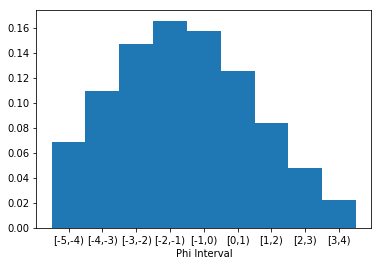

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 50, vent_height, 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))
    print(phi_step["interval"])
    display(input_table)

elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

[-5,-4)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,1.117079e+08,0.032,1024.0,12.169553,29.628570,17.459017,115.896185,81.151383,-34.372668,0.139422,65.705586,4.781930e+05,0.772141,8.748419,69.801688,99.687141,8.103728,6.638185,4.648107
1,3921.6,1.119669e+08,0.032,1024.0,11.863080,41.491650,17.459017,115.896185,81.151383,-35.260657,0.557689,114.400069,6.754806e+05,0.831014,9.071716,137.845520,196.863805,8.103728,6.638185,4.648107
2,4339.9,1.115556e+08,0.032,1024.0,11.564326,53.055975,17.459017,115.896185,81.151383,-36.171586,1.254800,158.233813,8.724483e+05,0.861279,9.260202,204.175766,291.593214,8.103728,6.638185,4.648107
3,4758.2,1.108561e+08,0.032,1024.0,11.273095,64.329070,17.459017,115.896185,81.151383,-37.106049,2.230756,199.182089,1.069217e+06,0.879675,9.382912,268.835580,383.936998,8.103728,6.638185,4.648107
4,5176.5,1.099898e+08,0.032,1024.0,10.989198,75.318268,17.459017,115.896185,81.151383,-38.064653,3.485556,238.110361,1.265905e+06,0.892028,9.468974,331.867030,473.955237,8.103728,6.638185,4.648107
5,5594.8,1.090110e+08,0.032,1024.0,10.712451,86.030718,17.459017,115.896185,81.151383,-39.048021,5.019200,275.501070,1.462626e+06,0.900891,9.532601,393.311123,561.706496,8.103728,6.638185,4.648107
6,6013.1,1.079489e+08,0.032,1024.0,10.442673,96.473391,17.459017,115.896185,81.151383,-40.056794,6.831689,311.659753,1.659493e+06,0.907557,9.581521,453.207834,647.247865,8.103728,6.638185,4.648107
7,6431.4,1.068207e+08,0.032,1024.0,10.179689,106.653081,17.459017,115.896185,81.151383,-41.091628,8.923022,346.796160,1.856615e+06,0.912751,9.620285,511.596133,730.634998,8.103728,6.638185,4.648107
8,6849.7,1.056374e+08,0.032,1024.0,9.923328,116.576409,17.459017,115.896185,81.151383,-42.153195,11.293200,381.062575,2.054097e+06,0.916911,9.651744,568.514006,811.922145,8.103728,6.638185,4.648107
9,7268.0,1.044065e+08,0.032,1024.0,9.673424,126.249833,17.459017,115.896185,81.151383,-43.242188,13.942222,414.574218,2.252045e+06,0.920316,9.677775,623.998485,891.162192,8.103728,6.638185,4.648107


[-4,-3)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,1.785087e+08,0.016,1024.0,17.210347,41.901125,24.690778,163.901957,114.765386,-24.305147,0.139422,65.705586,6.753394e+05,0.772141,8.748419,98.714494,140.978907,8.103728,6.638185,4.648107
1,3921.6,1.789226e+08,0.016,1024.0,16.776929,58.678054,24.690778,163.901957,114.765386,-24.933050,0.557689,114.400069,9.515630e+05,0.831014,9.071716,194.943004,278.407463,8.103728,6.638185,4.648107
2,4339.9,1.782653e+08,0.016,1024.0,16.354426,75.032480,24.690778,163.901957,114.765386,-25.577174,1.254800,158.233813,1.225479e+06,0.861279,9.260202,288.748138,412.375078,8.103728,6.638185,4.648107
3,4758.2,1.771475e+08,0.016,1024.0,15.942563,90.975043,24.690778,163.901957,114.765386,-26.237939,2.230756,199.182089,1.497258e+06,0.879675,9.382912,380.190924,542.968910,8.103728,6.638185,4.648107
4,5176.5,1.757632e+08,0.016,1024.0,15.541073,106.516116,24.690778,163.901957,114.765386,-26.915774,3.485556,238.110361,1.767067e+06,0.892028,9.468974,469.330855,670.273924,8.103728,6.638185,4.648107
5,5594.8,1.741991e+08,0.016,1024.0,15.149693,121.665809,24.690778,163.901957,114.765386,-27.611121,5.019200,275.501070,2.035068e+06,0.900891,9.532601,556.225924,794.372945,8.103728,6.638185,4.648107
6,6013.1,1.725019e+08,0.016,1024.0,14.768170,136.433978,24.690778,163.901957,114.765386,-28.324431,6.831689,311.659753,2.301420e+06,0.907557,9.581521,640.932666,915.346709,8.103728,6.638185,4.648107
7,6431.4,1.706990e+08,0.016,1024.0,14.396255,150.830233,24.690778,163.901957,114.765386,-29.056169,8.923022,346.796160,2.566276e+06,0.912751,9.620285,723.506190,1033.273923,8.103728,6.638185,4.648107
8,6849.7,1.688081e+08,0.016,1024.0,14.033706,164.863939,24.690778,163.901957,114.765386,-29.806810,11.293200,381.062575,2.829788e+06,0.916911,9.651744,804.000218,1148.231309,8.103728,6.638185,4.648107
9,7268.0,1.668411e+08,0.016,1024.0,13.680287,178.544225,24.690778,163.901957,114.765386,-30.576844,13.942222,414.574218,3.092102e+06,0.920316,9.677775,882.467120,1260.293658,8.103728,6.638185,4.648107


[-3,-2)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,2.397930e+08,0.008,1024.0,24.339106,59.257139,34.918033,231.79237,162.302765,-17.186334,0.139422,65.705586,9.541464e+05,0.772141,8.748419,139.603376,199.374283,8.103728,6.638185,4.648107
1,3921.6,2.403490e+08,0.008,1024.0,23.726160,82.983300,34.918033,231.79237,162.302765,-17.630328,0.557689,114.400069,1.342002e+06,0.831014,9.071716,275.691040,393.727610,8.103728,6.638185,4.648107
2,4339.9,2.394660e+08,0.008,1024.0,23.128651,106.111951,34.918033,231.79237,162.302765,-18.085793,1.254800,158.233813,1.724739e+06,0.861279,9.260202,408.351533,583.186427,8.103728,6.638185,4.648107
3,4758.2,2.379646e+08,0.008,1024.0,22.546189,128.658140,34.918033,231.79237,162.302765,-18.553025,2.230756,199.182089,2.102599e+06,0.879675,9.382912,537.671161,767.873997,8.103728,6.638185,4.648107
4,5176.5,2.361050e+08,0.008,1024.0,21.978396,150.636535,34.918033,231.79237,162.302765,-19.032326,3.485556,238.110361,2.475817e+06,0.892028,9.468974,663.734060,947.910474,8.103728,6.638185,4.648107
5,5594.8,2.340040e+08,0.008,1024.0,21.424901,172.061437,34.918033,231.79237,162.302765,-19.524011,5.019200,275.501070,2.844623e+06,0.900891,9.532601,786.622245,1123.412992,8.103728,6.638185,4.648107
6,6013.1,2.317240e+08,0.008,1024.0,20.885346,192.946783,34.918033,231.79237,162.302765,-20.028397,6.831689,311.659753,3.209241e+06,0.907557,9.581521,906.415668,1294.495730,8.103728,6.638185,4.648107
7,6431.4,2.293021e+08,0.008,1024.0,20.359378,213.306161,34.918033,231.79237,162.302765,-20.545814,8.923022,346.796160,3.569890e+06,0.912751,9.620285,1023.192266,1461.269995,8.103728,6.638185,4.648107
8,6849.7,2.267621e+08,0.008,1024.0,19.846657,233.152818,34.918033,231.79237,162.302765,-21.076598,11.293200,381.062575,3.926781e+06,0.916911,9.651744,1137.028013,1623.844290,8.103728,6.638185,4.648107
9,7268.0,2.241198e+08,0.008,1024.0,19.346847,252.499665,34.918033,231.79237,162.302765,-21.621094,13.942222,414.574218,4.280122e+06,0.920316,9.677775,1247.996969,1782.324384,8.103728,6.638185,4.648107


[-2,-1)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,2.707792e+08,0.004,1024.0,34.420693,83.802250,49.381557,327.803914,229.530772,-12.152573,0.139422,65.705586,1.348439e+06,0.772141,8.748419,197.428987,281.957814,8.103728,6.638185,4.648107
1,3921.6,2.714071e+08,0.004,1024.0,33.553858,117.356108,49.381557,327.803914,229.530772,-12.466525,0.557689,114.400069,1.894167e+06,0.831014,9.071716,389.886008,556.814926,8.103728,6.638185,4.648107
2,4339.9,2.704100e+08,0.004,1024.0,32.708852,150.064960,49.381557,327.803914,229.530772,-12.788587,1.254800,158.233813,2.430801e+06,0.861279,9.260202,577.496276,824.750155,8.103728,6.638185,4.648107
3,4758.2,2.687145e+08,0.004,1024.0,31.885126,181.950086,49.381557,327.803914,229.530772,-13.118969,2.230756,199.182089,2.958681e+06,0.879675,9.382912,760.381848,1085.937820,8.103728,6.638185,4.648107
4,5176.5,2.666146e+08,0.004,1024.0,31.082145,213.032231,49.381557,327.803914,229.530772,-13.457887,3.485556,238.110361,3.478142e+06,0.892028,9.468974,938.661709,1340.547849,8.103728,6.638185,4.648107
5,5594.8,2.642421e+08,0.004,1024.0,30.299386,243.331617,49.381557,327.803914,229.530772,-13.805560,5.019200,275.501070,3.989508e+06,0.900891,9.532601,1112.451848,1588.745889,8.103728,6.638185,4.648107
6,6013.1,2.616675e+08,0.004,1024.0,29.536340,272.867957,49.381557,327.803914,229.530772,-14.162215,6.831689,311.659753,4.493095e+06,0.907557,9.581521,1281.865332,1830.693418,8.103728,6.638185,4.648107
7,6431.4,2.589327e+08,0.004,1024.0,28.792509,301.660466,49.381557,327.803914,229.530772,-14.528084,8.923022,346.796160,4.989213e+06,0.912751,9.620285,1447.012380,2066.547846,8.103728,6.638185,4.648107
8,6849.7,2.560645e+08,0.004,1024.0,28.067411,329.727877,49.381557,327.803914,229.530772,-14.903405,11.293200,381.062575,5.478163e+06,0.916911,9.651744,1608.000436,2296.462618,8.103728,6.638185,4.648107
9,7268.0,2.530808e+08,0.004,1024.0,27.360574,357.088451,49.381557,327.803914,229.530772,-15.288422,13.942222,414.574218,5.960237e+06,0.920316,9.677775,1764.934240,2520.587316,8.103728,6.638185,4.648107


[-1,0)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,2.570371e+08,0.002,1024.0,48.678212,118.514279,69.836067,463.584741,324.60553,-8.593167,0.139422,65.705586,1.906053e+06,0.772141,8.748419,279.206751,398.748565,8.103728,6.638185,4.648107
1,3921.6,2.576331e+08,0.002,1024.0,47.452321,165.966599,69.836067,463.584741,324.60553,-8.815164,0.557689,114.400069,2.675046e+06,0.831014,9.071716,551.382081,787.455220,8.103728,6.638185,4.648107
2,4339.9,2.566866e+08,0.002,1024.0,46.257302,212.223901,69.836067,463.584741,324.60553,-9.042897,1.254800,158.233813,3.429322e+06,0.861279,9.260202,816.703065,1166.372855,8.103728,6.638185,4.648107
3,4758.2,2.550772e+08,0.002,1024.0,45.092378,257.316279,69.836067,463.584741,324.60553,-9.276512,2.230756,199.182089,4.169364e+06,0.879675,9.382912,1075.342322,1535.747993,8.103728,6.638185,4.648107
4,5176.5,2.530839e+08,0.002,1024.0,43.956791,301.273071,69.836067,463.584741,324.60553,-9.516163,3.485556,238.110361,4.895643e+06,0.892028,9.468974,1327.468119,1895.820949,8.103728,6.638185,4.648107
5,5594.8,2.508318e+08,0.002,1024.0,42.849803,344.122874,69.836067,463.584741,324.60553,-9.762005,5.019200,275.501070,5.608618e+06,0.900891,9.532601,1573.244491,2246.825984,8.103728,6.638185,4.648107
6,6013.1,2.483878e+08,0.002,1024.0,41.770692,385.893565,69.836067,463.584741,324.60553,-10.014198,6.831689,311.659753,6.308738e+06,0.907557,9.581521,1812.831337,2588.991460,8.103728,6.638185,4.648107
7,6431.4,2.457918e+08,0.002,1024.0,40.718757,426.612322,69.836067,463.584741,324.60553,-10.272907,8.923022,346.796160,6.996440e+06,0.912751,9.620285,2046.384532,2922.539991,8.103728,6.638185,4.648107
8,6849.7,2.430691e+08,0.002,1024.0,39.693314,466.305636,69.836067,463.584741,324.60553,-10.538299,11.293200,381.062575,7.672148e+06,0.916911,9.651744,2274.056025,3247.688580,8.103728,6.638185,4.648107
9,7268.0,2.402368e+08,0.002,1024.0,38.693694,504.999330,69.836067,463.584741,324.60553,-10.810547,13.942222,414.574218,8.336277e+06,0.920316,9.677775,2495.993938,3564.648768,8.103728,6.638185,4.648107


[0,1)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,2.051058e+08,0.001,1233.5,75.745350,183.493234,107.747884,715.250402,500.823723,-5.522451,0.139422,65.705586,2.949875e+06,0.772887,8.752181,434.457480,620.469585,8.103728,6.638185,4.648107
1,3921.6,2.055814e+08,0.001,1233.5,74.468260,257.961494,107.747884,715.250402,500.823723,-5.617158,0.557689,114.400069,4.152852e+06,0.832056,9.077936,861.589872,1230.477858,8.103728,6.638185,4.648107
2,4339.9,2.048261e+08,0.001,1233.5,73.212702,331.174196,107.747884,715.250402,500.823723,-5.713489,1.254800,158.233813,5.340139e+06,0.862479,9.268016,1281.520678,1830.201202,8.103728,6.638185,4.648107
3,4758.2,2.035419e+08,0.001,1233.5,71.978313,403.152509,107.747884,715.250402,500.823723,-5.811473,2.230756,199.182089,6.512077e+06,0.880977,9.391839,1694.371320,2419.813024,8.103728,6.638185,4.648107
4,5176.5,2.019513e+08,0.001,1233.5,70.764736,473.917245,107.747884,715.250402,500.823723,-5.911136,3.485556,238.110361,7.668999e+06,0.893402,9.478729,2100.261172,2999.483806,8.103728,6.638185,4.648107
5,5594.8,2.001542e+08,0.001,1233.5,69.571621,543.488866,107.747884,715.250402,500.823723,-6.012509,5.019200,275.501070,8.811234e+06,0.902320,9.543004,2499.307594,3569.381158,8.103728,6.638185,4.648107
6,6013.1,1.982040e+08,0.001,1233.5,68.398621,611.887487,107.747884,715.250402,500.823723,-6.115620,6.831689,311.659753,9.939105e+06,0.909029,9.592449,2891.625969,4129.669863,8.103728,6.638185,4.648107
7,6431.4,1.961325e+08,0.001,1233.5,67.245399,679.132886,107.747884,715.250402,500.823723,-6.220500,8.923022,346.796160,1.105293e+07,0.914260,9.631653,3277.329733,4680.511926,8.103728,6.638185,4.648107
8,6849.7,1.939599e+08,0.001,1233.5,66.111621,745.244507,107.747884,715.250402,500.823723,-6.327178,11.293200,381.062575,1.215302e+07,0.918451,9.663489,3656.530412,5222.066620,8.103728,6.638185,4.648107
9,7268.0,1.916998e+08,0.001,1233.5,64.996958,810.241466,107.747884,715.250402,500.823723,-6.435686,13.942222,414.574218,1.323969e+07,0.921884,9.689851,4029.337649,5754.490532,8.103728,6.638185,4.648107


[1,2)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,1.375821e+08,0.0005,1443.0,136.448214,330.546021,194.097807,1288.457174,902.187426,-3.065632,0.139422,65.705586,5.312131e+06,0.772887,8.752181,782.634803,1117.718334,8.103728,6.638185,4.648107
1,3921.6,1.379011e+08,0.0005,1443.0,134.147654,464.693675,194.097807,1288.457174,902.187426,-3.118206,0.557689,114.400069,7.473798e+06,0.832056,9.077936,1552.074139,2216.591588,8.103728,6.638185,4.648107
2,4339.9,1.373945e+08,0.0005,1443.0,131.885883,596.579559,194.097807,1288.457174,902.187426,-3.171681,1.254800,158.233813,9.603611e+06,0.862479,9.268016,2308.540488,3296.937496,8.103728,6.638185,4.648107
3,4758.2,1.365330e+08,0.0005,1443.0,129.662246,726.241805,194.097807,1288.457174,902.187426,-3.226074,2.230756,199.182089,1.170218e+07,0.880977,9.391839,3052.252578,4359.068436,8.103728,6.638185,4.648107
4,5176.5,1.354660e+08,0.0005,1443.0,127.476100,853.717905,194.097807,1288.457174,902.187426,-3.281399,3.485556,238.110361,1.377012e+07,0.893402,9.478729,3783.425451,5403.291516,8.103728,6.638185,4.648107
5,5594.8,1.342606e+08,0.0005,1443.0,125.326813,979.044718,194.097807,1288.457174,902.187426,-3.337674,5.019200,275.501070,1.580800e+07,0.902320,9.543004,4502.270521,6429.908670,8.103728,6.638185,4.648107
6,6013.1,1.329524e+08,0.0005,1443.0,123.213764,1102.258482,194.097807,1288.457174,902.187426,-3.394913,6.831689,311.659753,1.781642e+07,0.909029,9.592449,5208.995639,7439.216738,8.103728,6.638185,4.648107
7,6431.4,1.315629e+08,0.0005,1443.0,121.136342,1223.394824,194.097807,1288.457174,902.187426,-3.453134,8.923022,346.796160,1.979595e+07,0.914260,9.631653,5903.805150,8431.507558,8.103728,6.638185,4.648107
8,6849.7,1.301055e+08,0.0005,1443.0,119.093945,1342.488769,194.097807,1288.457174,902.187426,-3.512353,11.293200,381.062575,2.174715e+07,0.918451,9.663489,6586.899957,9407.068045,8.103728,6.638185,4.648107
9,7268.0,1.285895e+08,0.0005,1443.0,117.085984,1459.574753,194.097807,1288.457174,902.187426,-3.572588,13.942222,414.574218,2.367058e+07,0.921884,9.689851,7258.477573,10366.180277,8.103728,6.638185,4.648107


[2,3)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,7.757955e+07,0.00025,1652.5,249.314627,603.965092,354.650464,2354.235436,1648.453399,-1.677800,0.139422,65.705586,9.704335e+06,0.772887,8.752181,1430.009955,2042.265867,8.103728,6.638185,4.648107
1,3921.6,7.775944e+07,0.00025,1652.5,245.111105,849.076197,354.650464,2354.235436,1648.453399,-1.706573,0.557689,114.400069,1.364852e+07,0.832056,9.077936,2835.909497,4050.098495,8.103728,6.638185,4.648107
2,4339.9,7.747376e+07,0.00025,1652.5,240.978455,1090.054652,354.650464,2354.235436,1648.453399,-1.735840,1.254800,158.233813,1.753080e+07,0.862479,9.268016,4218.105133,6024.078439,8.103728,6.638185,4.648107
3,4758.2,7.698800e+07,0.00025,1652.5,236.915483,1326.970136,354.650464,2354.235436,1648.453399,-1.765609,2.230756,199.182089,2.135228e+07,0.880977,9.391839,5576.996521,7964.776465,8.103728,6.638185,4.648107
4,5176.5,7.638636e+07,0.00025,1652.5,232.921015,1559.891150,354.650464,2354.235436,1648.453399,-1.795888,3.485556,238.110361,2.511408e+07,0.893402,9.478729,6912.976575,9872.753717,8.103728,6.638185,4.648107
5,5594.8,7.570664e+07,0.00025,1652.5,228.993894,1788.885044,354.650464,2354.235436,1648.453399,-1.826686,5.019200,275.501070,2.881728e+07,0.902320,9.543004,8226.431590,11748.561877,8.103728,6.638185,4.648107
6,6013.1,7.496900e+07,0.00025,1652.5,225.132985,2014.018029,354.650464,2354.235436,1648.453399,-1.858013,6.831689,311.659753,3.246293e+07,0.909029,9.592449,9517.741343,13592.743327,8.103728,6.638185,4.648107
7,6431.4,7.418547e+07,0.00025,1652.5,221.337173,2235.355202,354.650464,2354.235436,1648.453399,-1.889877,8.923022,346.796160,3.605209e+07,0.914260,9.631653,10787.279211,15405.831303,8.103728,6.638185,4.648107
8,6849.7,7.336370e+07,0.00025,1652.5,217.605359,2452.960561,354.650464,2354.235436,1648.453399,-1.922287,11.293200,381.062575,3.958577e+07,0.918451,9.663489,12035.412274,17188.350050,8.103728,6.638185,4.648107
9,7268.0,7.250885e+07,0.00025,1652.5,213.936465,2666.897025,354.650464,2354.235436,1648.453399,-1.955253,13.942222,414.574218,4.306500e+07,0.921884,9.689851,13262.501425,18940.814974,8.103728,6.638185,4.648107


[3,4)


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,3503.3,3.677345e+07,0.000125,1862.0,483.432277,1159.520926,676.088649,4488.001611,3142.53256,-0.865271,0.139422,65.705586,1.862878e+07,0.774379,8.759736,2772.853624,3960.045377,8.103728,6.638185,4.648107
1,3921.6,3.685872e+07,0.000125,1862.0,483.432277,1642.953202,676.088649,4488.001611,3142.53256,-0.865271,0.557689,114.400069,2.640136e+07,0.834132,9.090394,5545.707249,7920.090754,8.103728,6.638185,4.648107
2,4339.9,3.672330e+07,0.000125,1862.0,483.432277,2126.385479,676.088649,4488.001611,3142.53256,-0.865271,1.254800,158.233813,3.417841e+07,0.864863,9.283609,8318.560873,11880.136130,8.103728,6.638185,4.648107
3,4758.2,3.649305e+07,0.000125,1862.0,483.432277,2609.817755,676.088649,4488.001611,3142.53256,-0.865271,2.230756,199.182089,4.195995e+07,0.883551,9.409589,11091.414498,15840.181507,8.103728,6.638185,4.648107
4,5176.5,3.620787e+07,0.000125,1862.0,483.432277,3093.250032,676.088649,4488.001611,3142.53256,-0.865271,3.485556,238.110361,4.974596e+07,0.896107,9.498054,13864.268122,19800.226884,8.103728,6.638185,4.648107
5,5594.8,3.588567e+07,0.000125,1862.0,483.432277,3576.682309,676.088649,4488.001611,3142.53256,-0.865271,5.019200,275.501070,5.753645e+07,0.905121,9.563535,16637.121747,23760.272261,8.103728,6.638185,4.648107
6,6013.1,3.553602e+07,0.000125,1862.0,483.432277,4060.114585,676.088649,4488.001611,3142.53256,-0.865271,6.831689,311.659753,6.533142e+07,0.911906,9.613938,19409.975371,27720.317637,8.103728,6.638185,4.648107
7,6431.4,3.516462e+07,0.000125,1862.0,483.432277,4543.546862,676.088649,4488.001611,3142.53256,-0.865271,8.923022,346.796160,7.313088e+07,0.917197,9.653923,22182.828996,31680.363014,8.103728,6.638185,4.648107
8,6849.7,3.477510e+07,0.000125,1862.0,483.432277,5026.979139,676.088649,4488.001611,3142.53256,-0.865271,11.293200,381.062575,8.093481e+07,0.921438,9.686413,24955.682620,35640.408391,8.103728,6.638185,4.648107
9,7268.0,3.436989e+07,0.000125,1862.0,483.432277,5510.411415,676.088649,4488.001611,3142.53256,-0.865271,13.942222,414.574218,8.874322e+07,0.924914,9.713333,27728.536245,39600.453768,8.103728,6.638185,4.648107


Forward Sim time: 0.45312 seconds
Dataframe Merge time: 0.03125 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.03125 seconds
Total time: 0.51562 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,16.601342,23.246399,23.847594,18.759100,11.673419,4.797837,0.986003,0.086738,0.001569,1313.788195,2124.861643,209.937391
1,1997,1957,13.828093,21.914481,24.252435,19.806746,12.801175,5.786376,1.453733,0.153770,0.003189,1128.919062,2796.043276,270.594214
2,2173,1787,13.798549,21.964540,24.342946,19.836648,12.753108,5.720793,1.429301,0.150979,0.003135,1145.501620,2813.413940,228.807450
3,3082,-770,15.705606,23.624646,24.604287,18.704620,11.245895,4.769544,1.207043,0.135355,0.003005,292.311698,3176.731654,49.168508
4,3152,-1673,16.467946,24.340387,24.691290,18.131829,10.571744,4.438503,1.203495,0.151092,0.003715,107.505725,3568.477687,85.894635


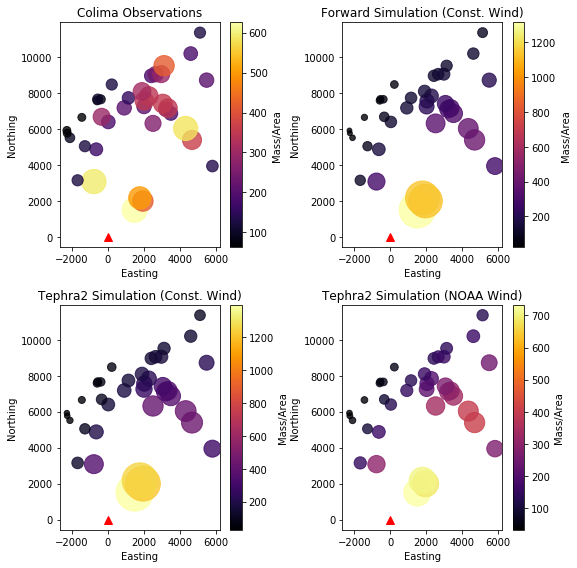

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


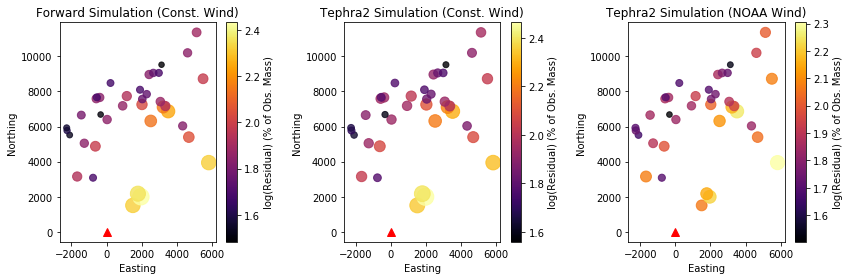

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

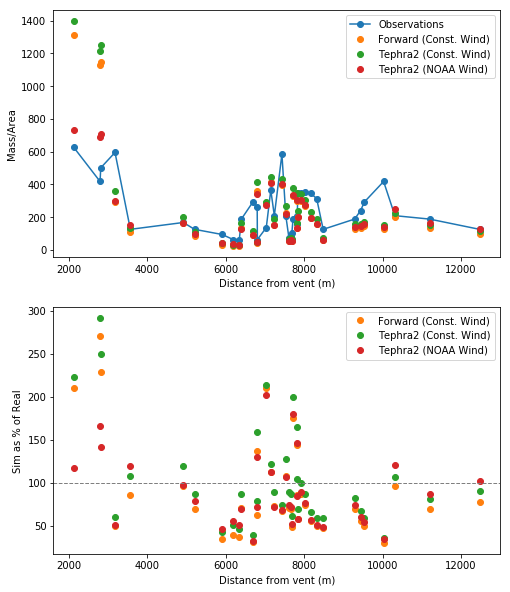

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
6.678494235186513
4.590001919974334
8.103727714748784
[-5,-4)
[-4,-3)
[-3,-2)
[-2,-1)
[-1,0)
[0,1)
[1,2)
[2,3)
[3,4)
a* = -2.56505	b* = -0.18502            	h1* = 1.82235
a = 1.07692	b = 1.83109	h1 = 25522.28027
Success: True, Optimization terminated successfully.
Iterations: 99
SSE: 0.3602477878669894


,Height,Suspended Mass
0,3354.15,9.540372e+08
1,3623.30,9.961163e+08
2,3892.45,1.017163e+09
3,4161.60,1.029155e+09
4,4430.75,1.035996e+09
5,4699.90,1.039471e+09
6,4969.05,1.040557e+09
7,5238.20,1.039845e+09
8,5507.35,1.037724e+09
9,5776.50,1.034462e+09


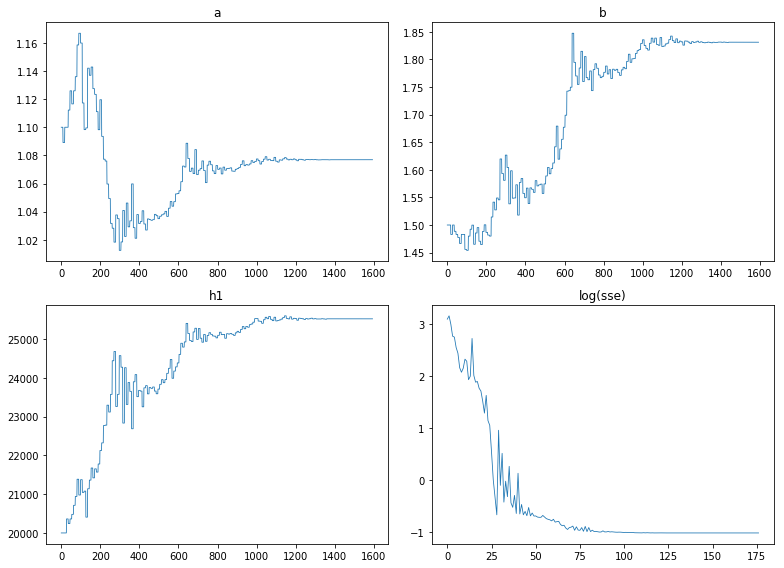

========T2 Const. Wind Simulation========
6.678494235186513
4.590001919974334
8.103727714748784
[-5,-4)
[-4,-3)
[-3,-2)
[-2,-1)
[-1,0)
[0,1)
[1,2)
[2,3)
[3,4)
a* = -1.11769	b* = 0.16956            	h1* = 1.32571
a = 1.32703	b = 2.18479	h1 = 23002.06020
Success: True, Optimization terminated successfully.
Iterations: 89
SSE: 19.842594451214737


,Height,Suspended Mass
0,3354.15,6.190503e+08
1,3623.30,7.639685e+08
2,3892.45,8.579590e+08
3,4161.60,9.268873e+08
4,4430.75,9.802030e+08
5,4699.90,1.022584e+09
6,4969.05,1.056744e+09
7,5238.20,1.084420e+09
8,5507.35,1.106803e+09
9,5776.50,1.124752e+09


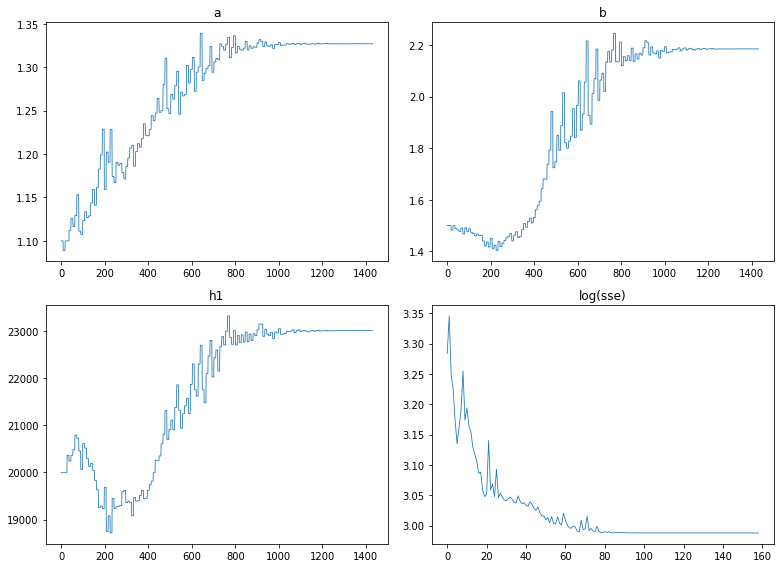

========T2 NOAA Wind Simulation========
6.678494235186513
4.590001919974334
8.103727714748784
[-5,-4)
[-4,-3)
[-3,-2)
[-2,-1)
[-1,0)
[0,1)
[1,2)
[2,3)
[3,4)
a* = -2.07734	b* = -2.03613            	h1* = 3.33894
a = 1.12526	b = 1.13053	h1 = 28954.41440
Success: True, Optimization terminated successfully.
Iterations: 91
SSE: 164.19143564164503


,Height,Suspended Mass
0,3354.15,4.148506e+08
1,3623.30,4.518564e+08
2,3892.45,4.747364e+08
3,4161.60,4.914627e+08
4,4430.75,5.046741e+08
5,4699.90,5.155893e+08
6,4969.05,5.248766e+08
7,5238.20,5.329442e+08
8,5507.35,5.400602e+08
9,5776.50,5.464109e+08


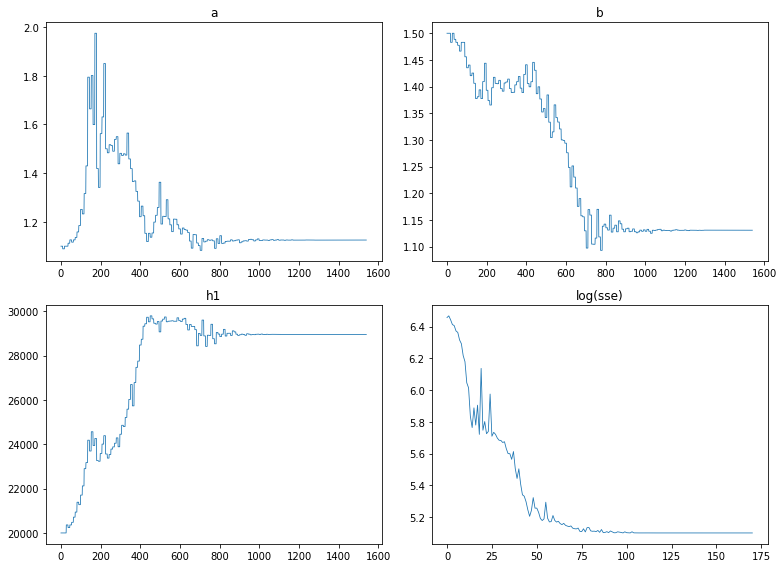

========Observation Data========
6.678494235186513
4.590001919974334
8.103727714748784
[-5,-4)
[-4,-3)
[-3,-2)
[-2,-1)
[-1,0)
[0,1)
[1,2)
[2,3)
[3,4)
a* = -2.82551	b* = -1.00703            	h1* = 2.50510
a = 1.05928	b = 1.36530	h1 = 27647.34437
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 936.4060595446829


,Height,Suspended Mass
0,3354.15,6.760445e+08
1,3623.30,7.015399e+08
2,3892.45,7.156544e+08
3,4161.60,7.249394e+08
4,4430.75,7.315058e+08
5,4699.90,7.363114e+08
6,4969.05,7.398749e+08
7,5238.20,7.425092e+08
8,5507.35,7.444183e+08
9,5776.50,7.457427e+08


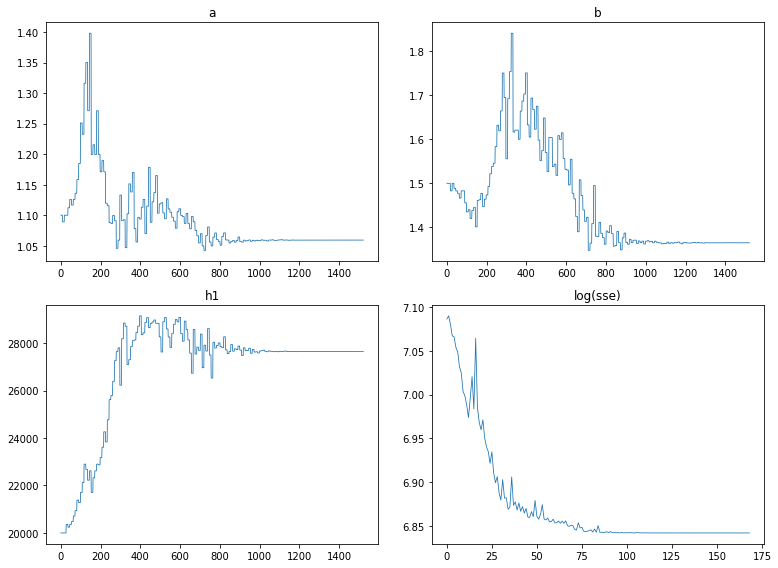

In [37]:
priors_vals = {
    "a": 1.1,
    "b": 1.5,
    "h1": 20000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h1" : True
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Const. Wind Simulation", "T2 Const. Wind Simulation","T2 NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 100, vent_height, H, 2500,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, _, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], vent_height, H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



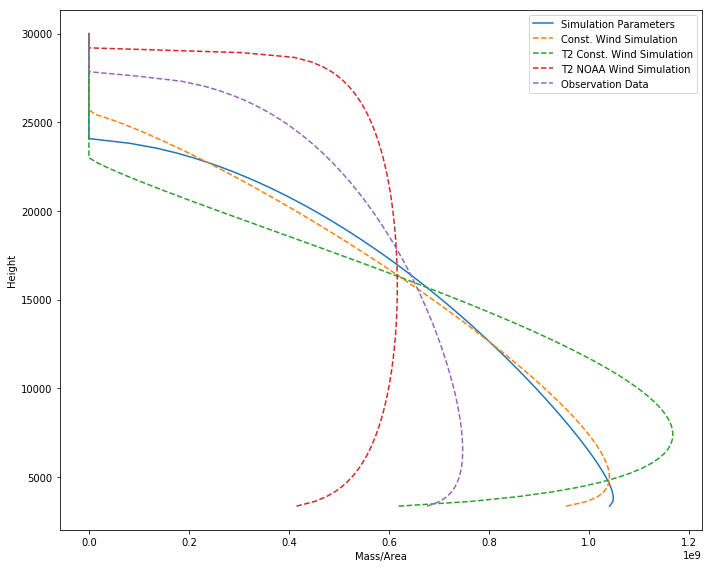

In [38]:
fig, ax1 = plt.subplots(1,1, figsize=(
    10, 8), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], vent_height, 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


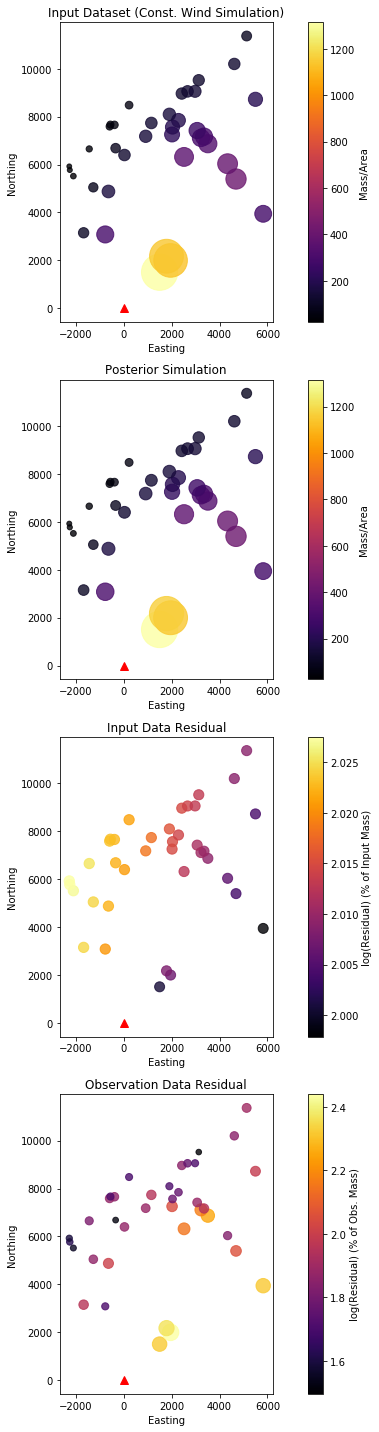

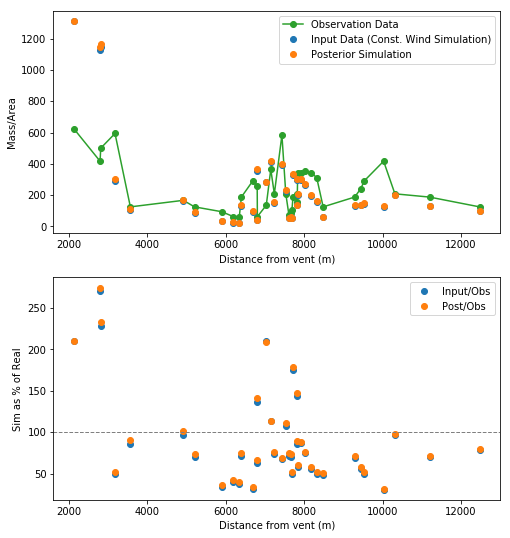

========T2 Const. Wind Simulation========


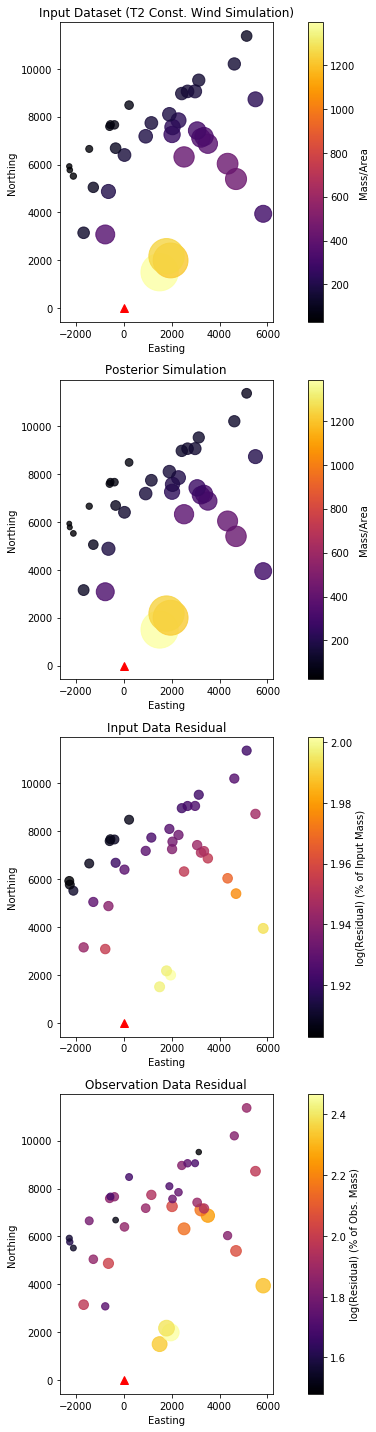

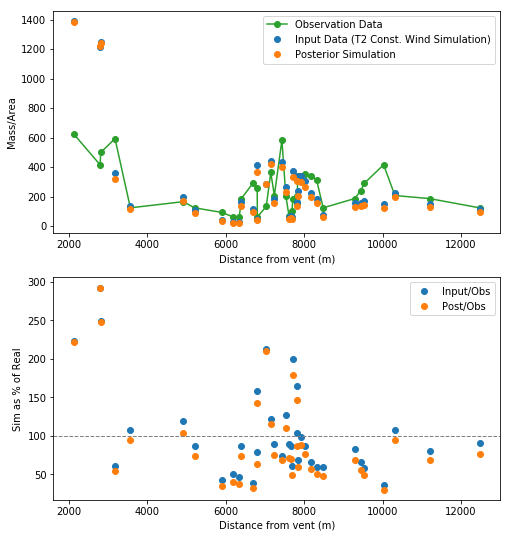

========T2 NOAA Wind Simulation========


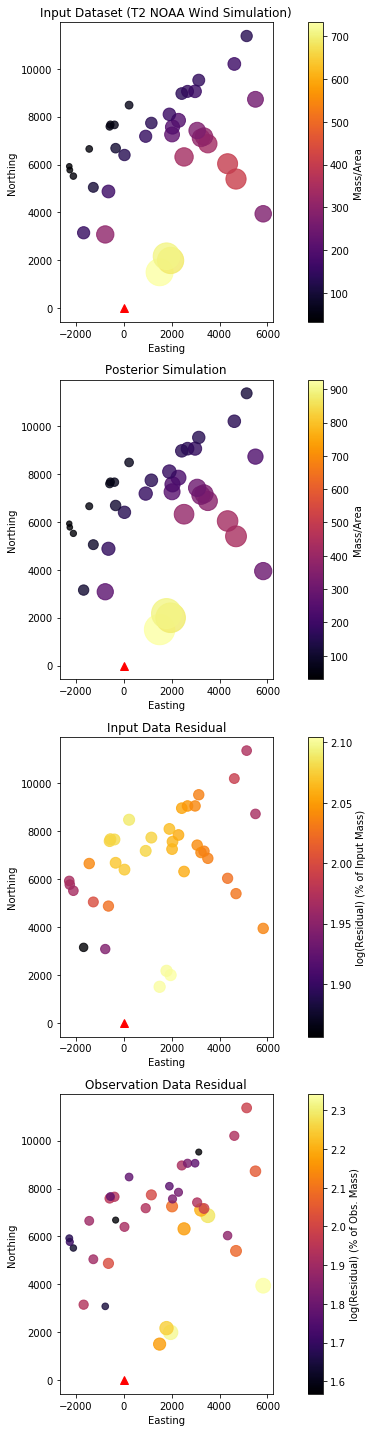

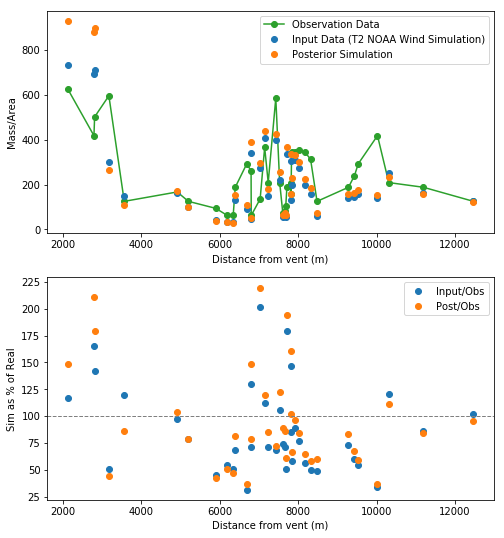

========Observation Data========


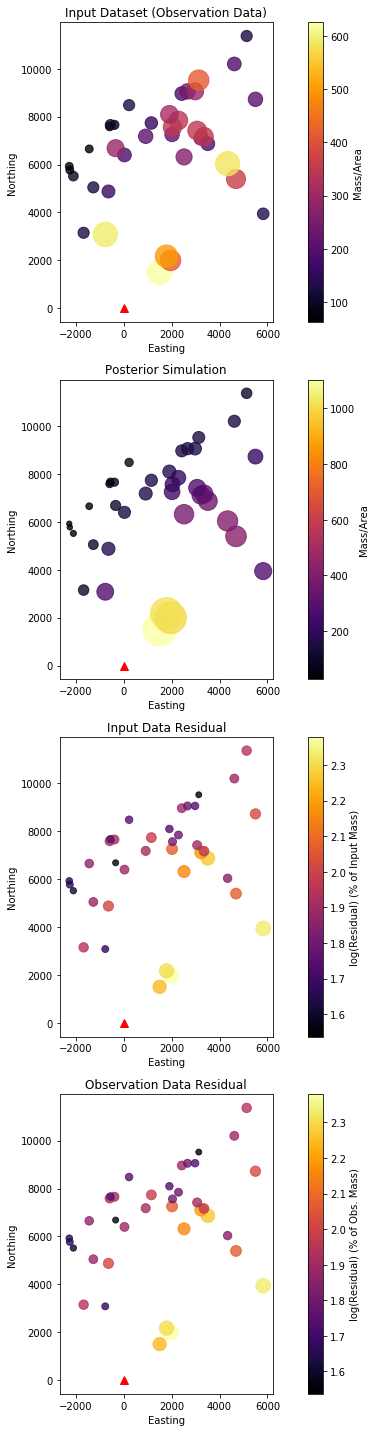

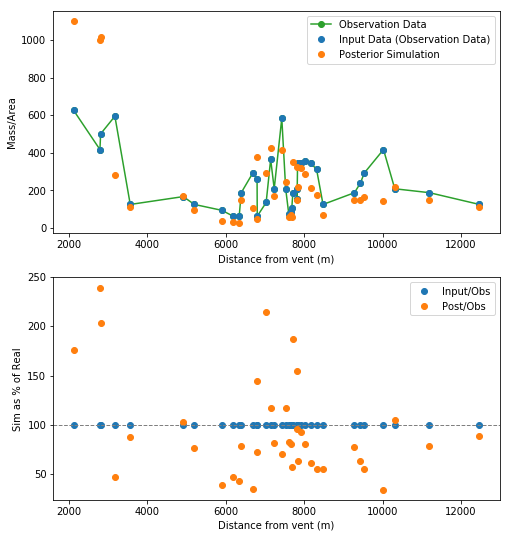

In [23]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), vent_height, 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values*100
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values*100
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Change",
                title="Input Data Residual", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Residual",
                title="Observation Data Residual", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [14]:
x = [(i, 2*i) for i in range(5)]
print(x)

a = [a[0] for a in x]
b = [b[1] for b in x]
print(a)
print(b)

[(0, 0), (1, 2), (2, 4), (3, 6), (4, 8)]
[0, 1, 2, 3, 4]
[0, 2, 4, 6, 8]


In [15]:
z_min = 3085
z_max = 24000
column_steps = 20

layer_thickness = ((z_max-z_min)/column_steps)
z = np.linspace(z_min + layer_thickness, z_max, column_steps)
print(layer_thickness)
print(z)

1045.75
[ 4130.75  5176.5   6222.25  7268.    8313.75  9359.5  10405.25 11451.
 12496.75 13542.5  14588.25 15634.   16679.75 17725.5  18771.25 19817.
 20862.75 21908.5  22954.25 24000.  ]


In [16]:
print([3]*5)

[3, 3, 3, 3, 3]


In [17]:
wind_sum_x = 239.863
wind_sum_y = 167.954
x_adj = 0.244392
y_adj = 0.171125

total_fall_time = 121.322

In [18]:
average_windspeed_x = (wind_sum_x + x_adj)/total_fall_time
average_windspeed_y = (wind_sum_y + y_adj)/total_fall_time

print(average_windspeed_x, average_windspeed_y)

1.9790919371589655 1.3857760752377968


In [19]:
average_windspeed = np.sqrt(average_windspeed_x**2 + average_windspeed_y**2)

print(average_windspeed)

2.416025708975196


In [20]:
u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

print(u, v)

5.664062369248328 8.241261886220157


In [21]:
0.959931 - np.pi/2

-0.6108653267948966